In this notebook we compute a scVI embedding of GEX and perform differential expression analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import scanpy as sc
import numpy as np
import scvi
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Global seed set to 0


In [3]:
adata = sc.read_h5ad("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_adata_GEX_with_umap.h5ad")

In [4]:
#adata.obs['time'] = adata.obs.apply(lambda x: 0 if x["sample"]=="E14.5" else 1, axis=1)

# scVI on GEX space

In [5]:
adata

AnnData object with n_obs × n_vars = 16978 × 14663
    obs: 'n_counts', 'sample', 'int_id', 'reporter', 'log_cell_probs', 'cell_barcodes_du', 'cell_barcodes_cr', 'cell_barcodes', 'log_counts', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'total_counts_rank', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'log_nCount_ATAC', 'log_nFeature_ATAC', 'scrublet_scores', 'scrublet_doublets', 'scrublet_doublets_cat', 'dd_doublets', 'dd_scores', 'dd_log_p_values', 'dd_voting_average', 'dd_-log_p_values', 'dd_doublets_cat', 'pANN', 'DF_classifications_1', 'DF_classifications_2', 'pANN_SCT', 'DF_SCT_classifications_1', 'DF_SCT_classifications_2', 'df_doublets',

In [6]:
adata.layers["counts"] = adata.layers["sct_counts"]

In [7]:
np.isfinite(adata.layers["counts"].A).all()

True

In [8]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="cell_ranger"
)


In [9]:
scvi.model.SCVI.setup_anndata(adata, layer="counts")

In [10]:
vae = scvi.model.SCVI(adata)
vae.train()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/icb/dominik.klein/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 400/400: 100%|██████████| 400/400 [06:34<00:00,  1.01it/s, loss=1.14e+03, v_num=1]


In [15]:
vae


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [23]:
vae.history["train_loss_step"]

train_loss_step
epoch                
0         1287.557251
1           1213.4104
2         1278.576172
3         1189.765137
4         1191.163818
...               ...
395       1197.247925
396       1164.897095
397       1100.270874
398        1153.99585
399       1144.196411

[400 rows x 1 columns]

In [27]:
vae.history.keys()

dict_keys(['train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

<AxesSubplot:xlabel='epoch', ylabel='kl_global_train'>

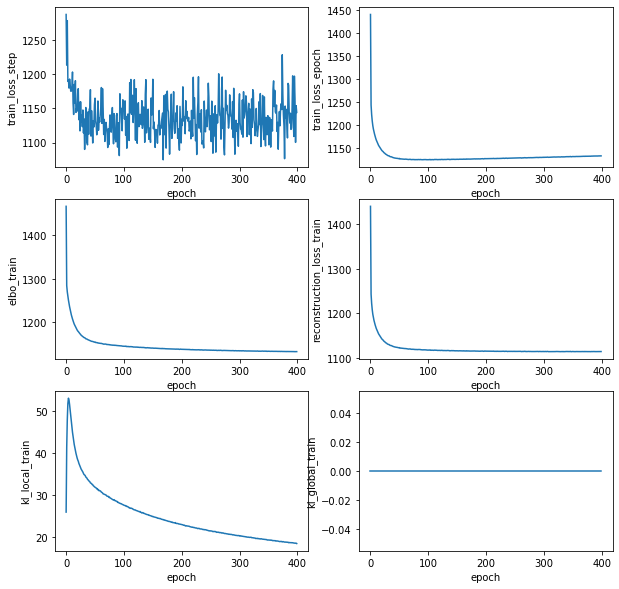

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

sns.lineplot(data=vae.history['train_loss_step'], x="epoch", y="train_loss_step", ax=axs[0][0])
sns.lineplot(data=vae.history['train_loss_epoch'], x="epoch", y="train_loss_epoch", ax=axs[0][1])
sns.lineplot(data=vae.history['elbo_train'], x="epoch", y="elbo_train", ax=axs[1][0])
sns.lineplot(data=vae.history['reconstruction_loss_train'], x="epoch", y='reconstruction_loss_train', ax=axs[1][1])
sns.lineplot(data=vae.history['kl_local_train'], x="epoch", y='kl_local_train', ax=axs[2][0])
sns.lineplot(data=vae.history['kl_global_train'], x="epoch", y='kl_global_train', ax=axs[2][1])

In [32]:
adata.obsm["X_scVI"]=vae.get_latent_representation()
adata.layers["scvi_normalized"] = vae.get_normalized_expression()


In [33]:
adata.obsm["X_scVI_pca"] = sc.pp.pca(adata.obsm["X_scVI"])

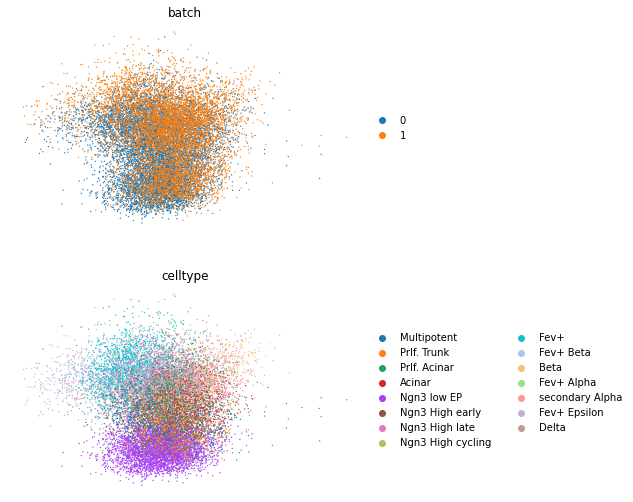

In [34]:
sc.pl.embedding(
    adata,
    basis="X_scVI",
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
)

In [35]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, key_added="scVI")

Seems like there is a seperation between two types of Multipotent cells in scVI space (similar to PCA space)

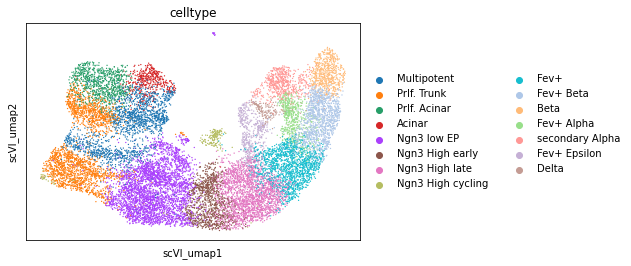

In [38]:

sc.pl.embedding(adata, basis="scVI_umap", color=["celltype"])

/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['neighbors_wnn']['connectivities'] that happens to be dimensioned at n_obs×n_obs (16978×16978).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


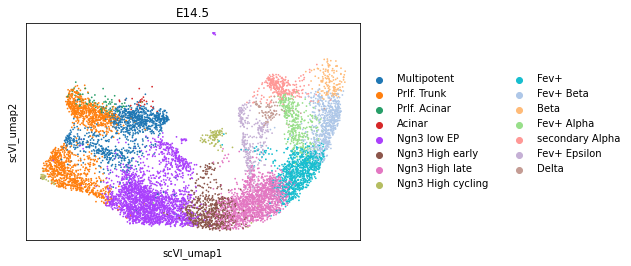

In [51]:

sc.pl.embedding(adata[adata.obs["batch"]=="0"], basis="scVI_umap", color=["celltype"], title="E14.5")

/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['neighbors_wnn']['connectivities'] that happens to be dimensioned at n_obs×n_obs (16978×16978).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


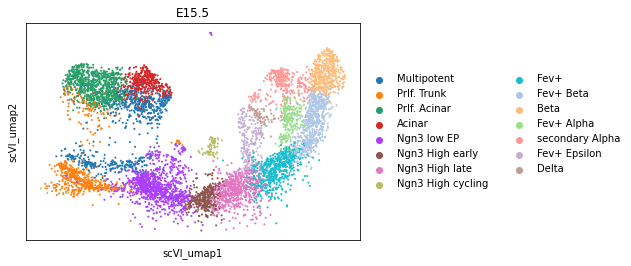

In [52]:
sc.pl.embedding(adata[adata.obs["batch"]=="1"], basis="scVI_umap", color=["celltype"], title="E15.5")

Let's compare it with the UMAP from the normal (50-dim. PCA) space

/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['neighbors_wnn']['connectivities'] that happens to be dimensioned at n_obs×n_obs (16978×16978).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


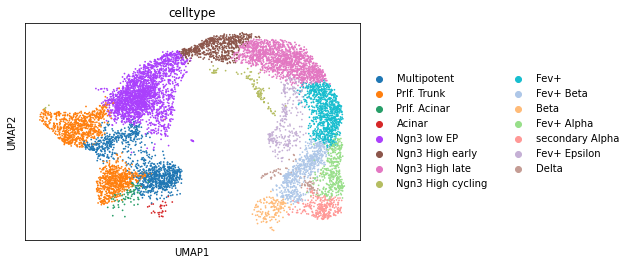

/home/icb/dominik.klein/miniconda3/envs/moscot_env_05/lib/python3.9/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['neighbors_wnn']['connectivities'] that happens to be dimensioned at n_obs×n_obs (16978×16978).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


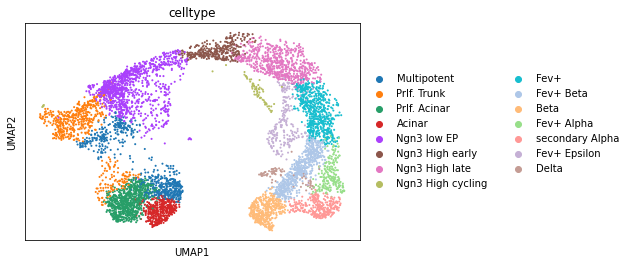

In [50]:
sc.pl.embedding(adata[adata.obs["batch"]=="0"], basis="umap", color=["celltype"])
sc.pl.embedding(adata[adata.obs["batch"]=="1"], basis="umap", color=["celltype"])

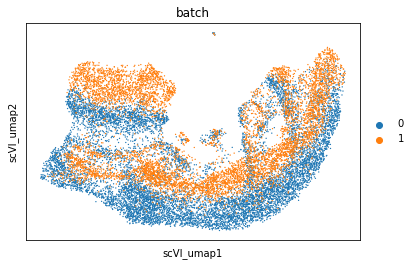

In [40]:
sc.pl.embedding(adata, basis="scVI_umap", color=["batch"])

In [53]:
de_df = vae.differential_expression(
    groupby="celltype",
)
de_df.head()

DE...: 100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


proba_de  proba_not_de  bayes_factor    scale1    scale2  \
Olfr1369-ps1    0.9772        0.0228      3.757930  0.000032  0.000012   
Slit3           0.9762        0.0238      3.713981  0.002208  0.000683   
Chst9           0.9732        0.0268      3.592187  0.000015  0.000228   
Camk2n1         0.9710        0.0290      3.511030  0.000130  0.001158   
Gm49016         0.9706        0.0294      3.496919  0.000091  0.000033   

              pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
Olfr1369-ps1           0.0   0.25  3.469807    3.815587  3.160739  ...   
Slit3                  0.0   0.25  3.517136    3.912631  2.533656  ...   
Chst9                  0.0   0.25 -3.412381   -3.680585  2.769994  ...   
Camk2n1                0.0   0.25 -2.553191   -3.019847  2.150182  ...   
Gm49016                0.0   0.25  3.130840    3.477628  2.855908  ...   

              raw_mean1  raw_mean2  non_zeros_proportion1  \
Olfr1369-ps1   0.006344   0.002296               0.004037   
Slit3          4.234721   1.340197               0.818916   
Chst9          0.010957   0.397858               0.009804   
Camk2n1        0.160900   2.089984               0.141869   
Gm49016        0.051326   0.023747               0.028258   

              non_zeros_proportion2  raw_normalized_mean1  \
Olfr1369-ps1               0.001181              0.038361   
Slit3                      0.186303             23.630482   
Chst9                      0.158751              0.065194   
Camk2n1                    0.616833              0.960647   
Gm49016                    0.015219              0.278898   

              raw_normalized_mean2  is_de_fdr_0.05           comparison  \
Olfr1369-ps1              0.011247            True  Multipotent vs Rest   
Slit3                     6.364360            True  Multipotent vs Rest   
Chst9                     1.957571            True  Multipotent vs Rest   
Camk2n1                  11.521871            True  Multipotent vs Rest   
Gm49016                   0.111347            True  Multipotent vs Rest   

                   group1 group2  
Olfr1369-ps1  Multipotent   Rest  
Slit3         Multipotent   Rest  
Chst9         Multipotent   Rest  
Camk2n1       Multipotent   Rest  
Gm49016       Multipotent   Rest  

[5 rows x 22 columns]

In [54]:
markers = {}
cats = adata.obs.celltype.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [55]:
markers

{'Multipotent': ['Slit3', 'Ccbe1', 'Nepn'],
 'Prlf. Trunk': ['Esco2', 'Anln', 'Cdca2'],
 'Prlf. Acinar': ['Cpb1', 'Gm10334', '2210010C04Rik'],
 'Acinar': ['Cela2a', 'Cela3b', 'Try10'],
 'Ngn3 low EP': ['Gm14226', 'Gm35533', 'Cxcl12'],
 'Ngn3 High early': ['Map1b', 'Bcl2', 'Dll1'],
 'Ngn3 High late': ['Wnt3', 'Notum', 'Pou3f1'],
 'Ngn3 High cycling': ['Nusap1', 'Lockd', 'Ckap2l'],
 'Fev+': ['Sulf1', 'Clstn2', 'Pcsk2'],
 'Fev+ Beta': ['Tac1', 'Lmo3', 'Slc30a8'],
 'Beta': ['Gm31218', 'Sntg1', 'Mapt'],
 'Fev+ Alpha': ['Cntnap5b', 'Gm13629', 'Scn9a'],
 'secondary Alpha': ['Gcg', 'Irx1', 'Wnk3'],
 'Fev+ Epsilon': ['Mboat4', 'Lrrtm3', 'Irs4'],
 'Delta': ['Mboat4', 'Rbp4', 'Arg1']}

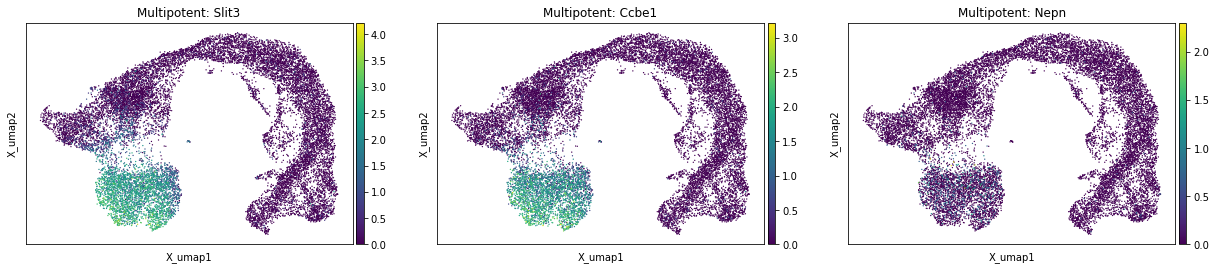

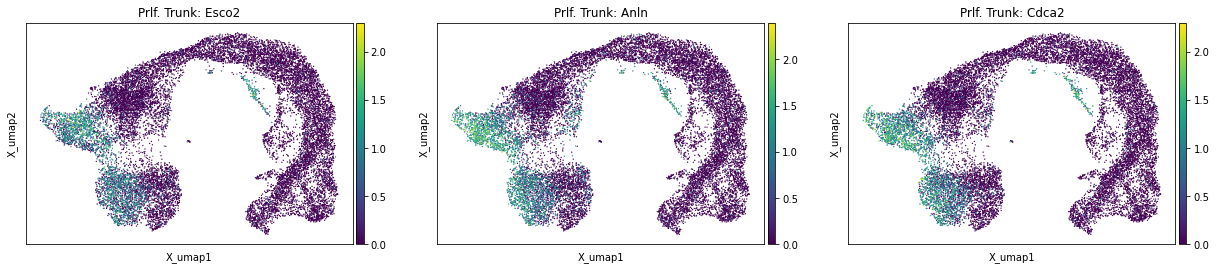

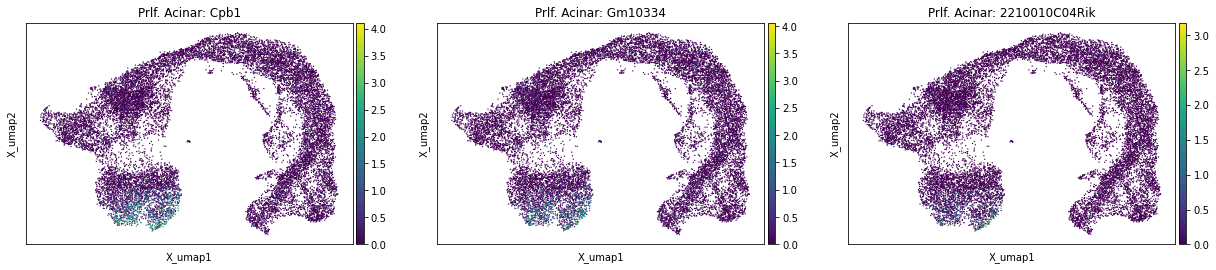

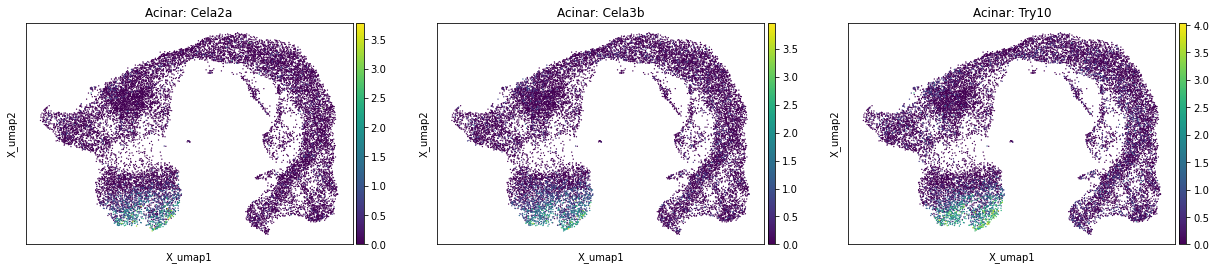

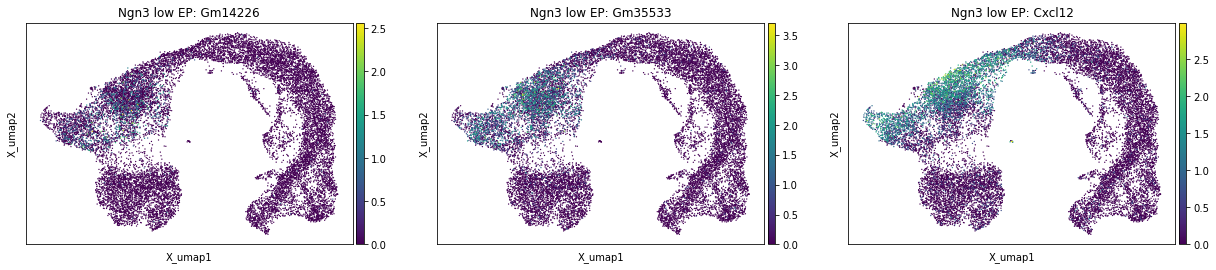

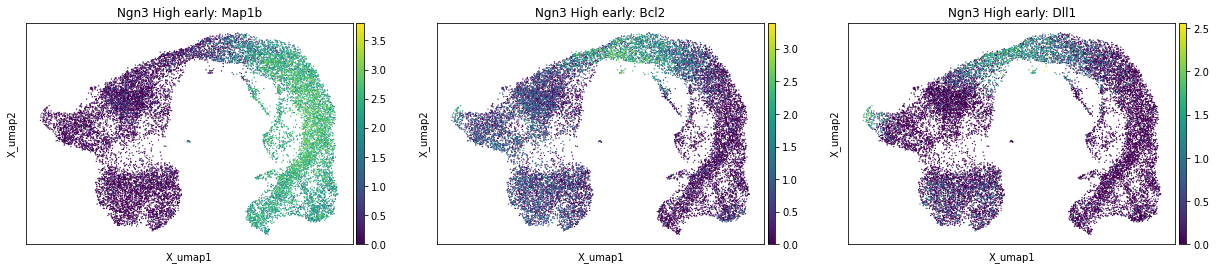

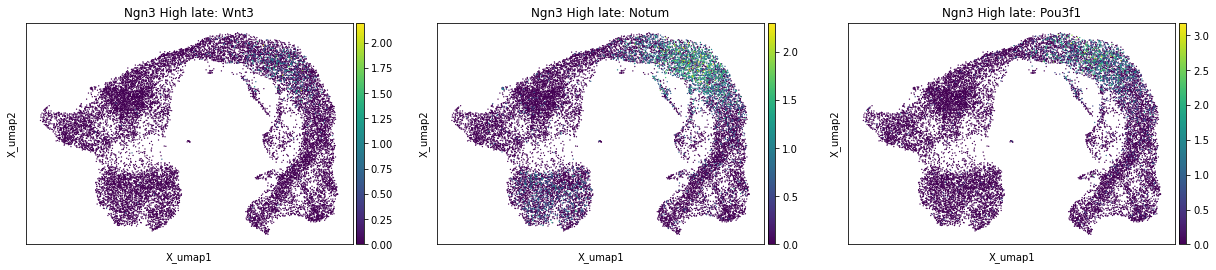

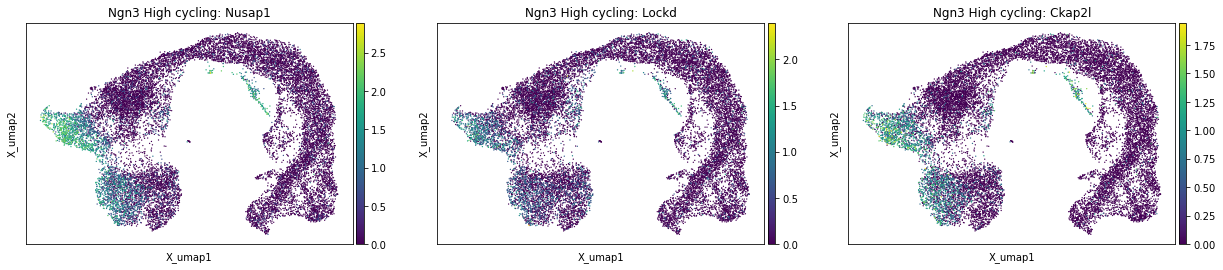

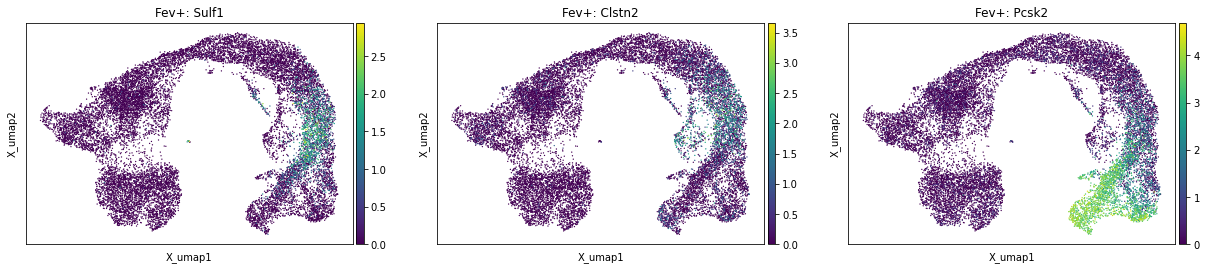

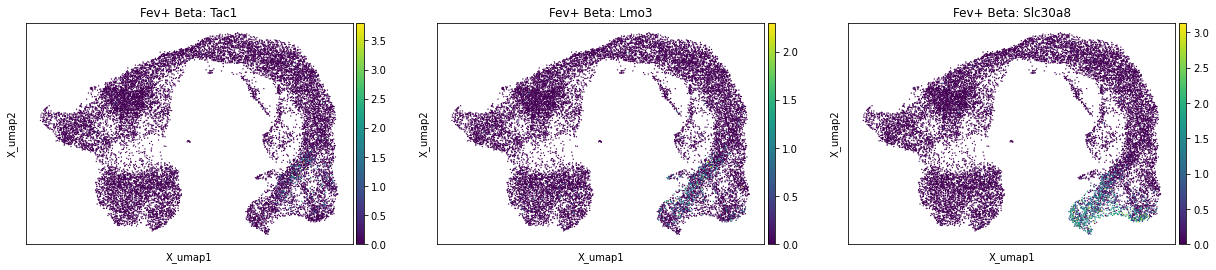

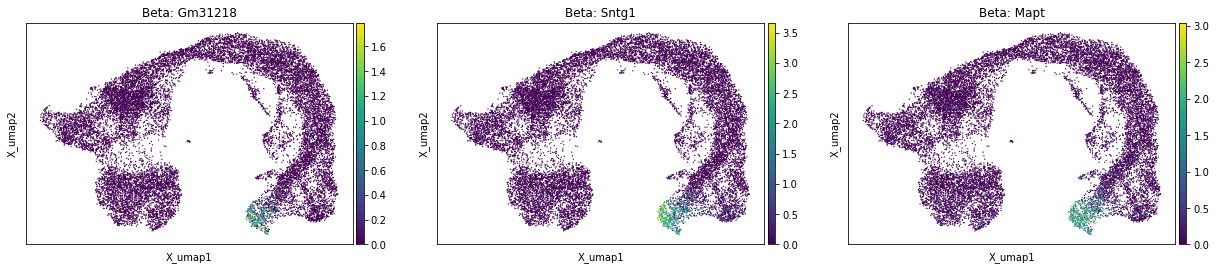

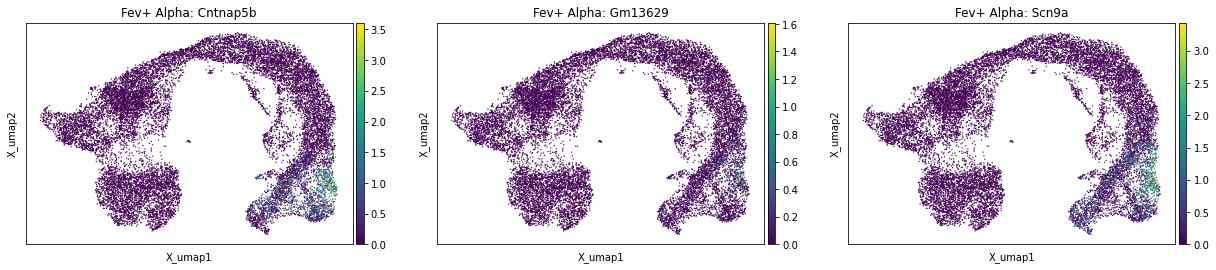

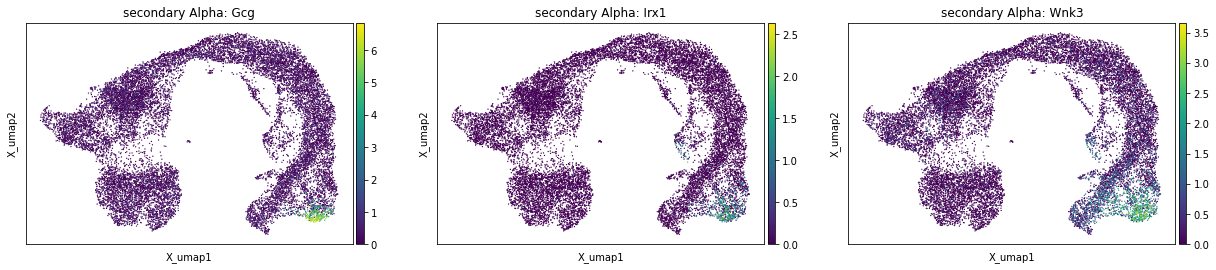

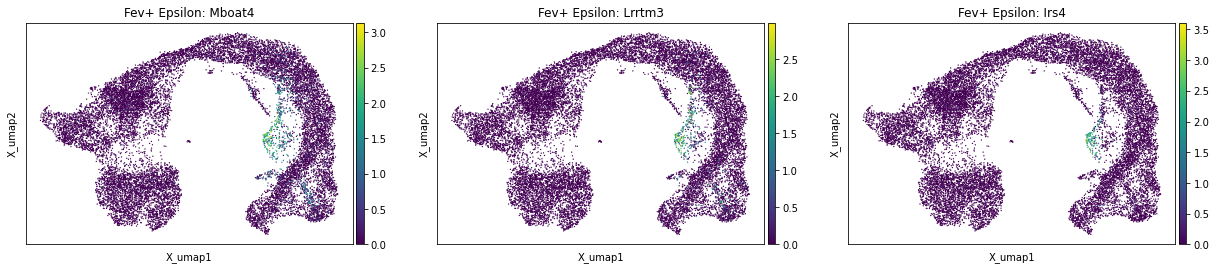

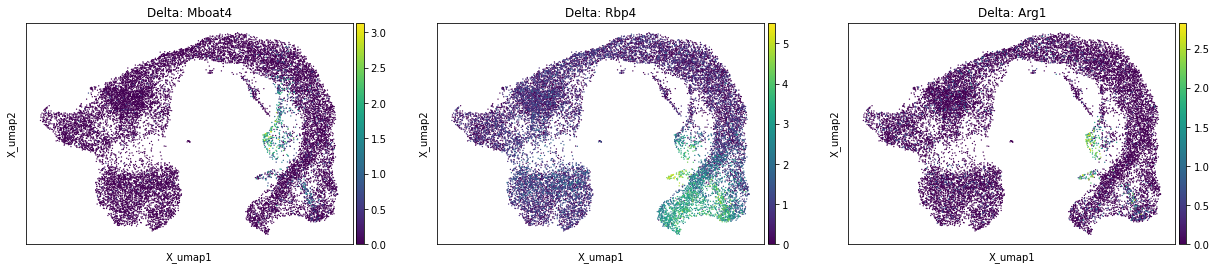

In [57]:
for celltype, marks in markers.items():
    title = [f"{celltype}: {mark}" for mark in marks]
    sc.pl.embedding(adata, basis="X_umap", color=marks, title=title)

In [58]:
adata.write("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_adata_with_scVI_embedding.h5ad")

In [59]:
vae.save("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/models/sc_vi", overwrite=False, save_anndata=True)

In [19]:
#bdata = sc.read_h5ad("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_adata_with_scVI_embedding.h5ad")

In [20]:
#cdata = sc.read_h5ad("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_adata_with_scVI_embedding.h5ad")